# Projet Navires 2025 - Pierre CHHIENG & Rick GAO - MacBoat

cf https://keras.io/api/data_loading/image/ et https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

## Extraction des données

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

2025-08-05 17:35:07.745874: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 17:35:07.745941: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 17:35:07.745997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 17:35:07.758199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 17:35:08.689535: W tensorflow/compiler/

## Code
### GPU Optimization

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


2025-08-05 17:35:24.774225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-05 17:35:24.863536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-05 17:35:24.863630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-05 17:35:24.865774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-05 17:35:24.866130: I tensorflow/compile

### Hyperparamètres

In [3]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
EPOCHS = 100
SEED = 777

### Préparation et augmentation des jeux de données

- Chargement des images avec un redimensionnement (IMG_SIZE) et un batch  (BATCH_SIZE)
- Les images sont normalisées entre 0 et 1
- Une data augmentation légère est appliquée au jeu d'entraînement pour améliorer la généralisation (flip horizontal, rotation, zoom).
- La pipeline est optimisée avec shuffle et prefetch pour accélérer l'entraînement

In [4]:
train_df, test_df = keras.utils.image_dataset_from_directory(
    "./dataset/ships32",
    seed=SEED,
    subset="both",
    validation_split=0.2,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

normalization_layer = keras.layers.Rescaling(1./255)

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE
train_df = train_df.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
test_df = test_df.map(lambda x, y: (normalization_layer(x), y))

train_df = train_df.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_df = test_df.prefetch(buffer_size=AUTOTUNE)

Found 48330 files belonging to 13 classes.
Using 38664 files for training.
Using 9666 files for validation.


### Model

- On prend un input de taille (64, 64, 3) pour capturer un maximum de details dans l'image
- Bloc 1 : 32 filtres, extraction patterns de base, normaliser, reduire la taille de l'image et regularisation (dropout pour eviter l'overfitting)
- Bloc 2 : Idem, avec 64 filtres
- Bloc 3 : Idem, avec 128 filtres
- Bloc 4 : Idem, avec 256 filtres
- Bloc 5 : Moyenne des patterns, regularisation (eviter l'overfitting), detecter un pattern global, puis softmax donne la probabilite pour les 13 classes

In [5]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = keras.layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Dropout(0.1)(x)

    x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Dropout(0.1)(x)

    x = keras.layers.SeparableConv2D(128, 3, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x) 
    x = keras.layers.SeparableConv2D(128, 3, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D()(x)

    x = keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D()(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

model = make_model(input_shape=(IMG_SIZE) + (3,), num_classes=13)
keras.utils.plot_model(model, show_shapes=True)

print("Nombre de couches : ", len(model.layers))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Nombre de couches :  29


## Train model

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_df,
    validation_data=test_df,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/100


2025-08-05 17:35:50.444608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-05 17:36:00.717487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 308 of 1000
2025-08-05 17:36:10.068407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2025-08-05 17:36:10.194274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2025-08-05 17:36:15.236089: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7a487a57bac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-05 17:36:15.236147: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capabilit

604/605 [============================>.] - ETA: 0s - loss: 1.8656 - accuracy: 0.3839

/home/rickgao/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


605/605 [==============================] - 55s 38ms/step - loss: 1.8652 - accuracy: 0.3839 - val_loss: 1.8858 - val_accuracy: 0.3926 - lr: 0.0010
Epoch 2/100


2025-08-05 17:36:53.620539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 17:37:01.616916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 1.3701 - accuracy: 0.5422 - val_loss: 1.3939 - val_accuracy: 0.5252 - lr: 0.0010
Epoch 3/100


2025-08-05 17:37:34.003468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 17:37:42.092162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 1.1843 - accuracy: 0.6007 - val_loss: 1.1602 - val_accuracy: 0.6060 - lr: 0.0010
Epoch 4/100


2025-08-05 17:38:14.477302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 356 of 1000
2025-08-05 17:38:21.954422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 37ms/step - loss: 1.0758 - accuracy: 0.6351 - val_loss: 1.0740 - val_accuracy: 0.6384 - lr: 0.0010
Epoch 5/100


2025-08-05 17:38:54.997769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 351 of 1000
2025-08-05 17:39:02.443684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 37ms/step - loss: 1.0045 - accuracy: 0.6586 - val_loss: 1.0142 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 6/100


2025-08-05 17:39:35.215274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 17:39:42.957007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 37ms/step - loss: 0.9404 - accuracy: 0.6803 - val_loss: 0.9257 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 7/100


2025-08-05 17:40:15.594889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 17:40:23.203158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.9033 - accuracy: 0.6917 - val_loss: 0.9240 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 8/100


2025-08-05 17:40:55.564535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 17:41:03.260426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.8617 - accuracy: 0.7023 - val_loss: 0.9294 - val_accuracy: 0.6849 - lr: 0.0010
Epoch 9/100


2025-08-05 17:41:35.512309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 17:41:43.231862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.8328 - accuracy: 0.7126 - val_loss: 0.8720 - val_accuracy: 0.7152 - lr: 0.0010
Epoch 10/100


2025-08-05 17:42:15.592304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 349 of 1000
2025-08-05 17:42:23.156034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 37ms/step - loss: 0.8042 - accuracy: 0.7234 - val_loss: 0.8891 - val_accuracy: 0.7006 - lr: 0.0010
Epoch 11/100


2025-08-05 17:42:56.417149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 326 of 1000
2025-08-05 17:43:05.190228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 42s 37ms/step - loss: 0.7785 - accuracy: 0.7314 - val_loss: 0.8396 - val_accuracy: 0.7101 - lr: 0.0010
Epoch 12/100


2025-08-05 17:43:38.376144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 327 of 1000
2025-08-05 17:43:46.861979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 42s 38ms/step - loss: 0.7533 - accuracy: 0.7399 - val_loss: 0.8131 - val_accuracy: 0.7214 - lr: 0.0010
Epoch 13/100


2025-08-05 17:44:20.384034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 297 of 1000
2025-08-05 17:44:31.710761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 46s 40ms/step - loss: 0.7319 - accuracy: 0.7470 - val_loss: 0.8331 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 14/100


2025-08-05 17:45:06.217406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 300 of 1000
2025-08-05 17:45:16.221598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 600 of 1000
2025-08-05 17:45:16.363213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 43s 37ms/step - loss: 0.7201 - accuracy: 0.7516 - val_loss: 0.8944 - val_accuracy: 0.7022 - lr: 0.0010
Epoch 15/100


2025-08-05 17:45:49.335277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 327 of 1000
2025-08-05 17:45:58.287894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 43s 40ms/step - loss: 0.6960 - accuracy: 0.7574 - val_loss: 0.7407 - val_accuracy: 0.7428 - lr: 0.0010
Epoch 16/100


2025-08-05 17:46:32.805193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 301 of 1000
2025-08-05 17:46:42.808376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 604 of 1000
2025-08-05 17:46:42.815672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 43s 37ms/step - loss: 0.6824 - accuracy: 0.7625 - val_loss: 0.7552 - val_accuracy: 0.7414 - lr: 0.0010
Epoch 17/100


2025-08-05 17:47:15.757028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 332 of 1000
2025-08-05 17:47:24.530308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 41s 37ms/step - loss: 0.6673 - accuracy: 0.7676 - val_loss: 0.7003 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 18/100


2025-08-05 17:47:57.262680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 327 of 1000
2025-08-05 17:48:05.855067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 41s 37ms/step - loss: 0.6580 - accuracy: 0.7711 - val_loss: 0.7581 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 19/100


2025-08-05 17:48:38.863201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 328 of 1000
2025-08-05 17:48:47.372898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 41s 37ms/step - loss: 0.6357 - accuracy: 0.7783 - val_loss: 0.6924 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 20/100


2025-08-05 17:49:19.955393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 306 of 1000
2025-08-05 17:49:29.379169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 41s 36ms/step - loss: 0.6365 - accuracy: 0.7781 - val_loss: 0.8099 - val_accuracy: 0.7293 - lr: 0.0010
Epoch 21/100


2025-08-05 17:50:01.705878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 332 of 1000
2025-08-05 17:50:10.124273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.6150 - accuracy: 0.7836 - val_loss: 0.7798 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 22/100


2025-08-05 17:50:42.521414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 334 of 1000
2025-08-05 17:50:50.680174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.7878
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
605/605 [==============================] - 40s 36ms/step - loss: 0.6077 - accuracy: 0.7878 - val_loss: 0.7719 - val_accuracy: 0.7390 - lr: 0.0010
Epoch 23/100


2025-08-05 17:51:22.905920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 348 of 1000
2025-08-05 17:51:30.608388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.5397 - accuracy: 0.8081 - val_loss: 0.6579 - val_accuracy: 0.7746 - lr: 5.0000e-04
Epoch 24/100


2025-08-05 17:52:03.101525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 349 of 1000
2025-08-05 17:52:10.649387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.5179 - accuracy: 0.8149 - val_loss: 0.6586 - val_accuracy: 0.7795 - lr: 5.0000e-04
Epoch 25/100


2025-08-05 17:52:43.292975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 17:52:50.997517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.4957 - accuracy: 0.8242 - val_loss: 0.6430 - val_accuracy: 0.7843 - lr: 5.0000e-04
Epoch 26/100


2025-08-05 17:53:23.354956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 350 of 1000
2025-08-05 17:53:30.849558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 39s 36ms/step - loss: 0.4867 - accuracy: 0.8272 - val_loss: 0.6549 - val_accuracy: 0.7814 - lr: 5.0000e-04
Epoch 27/100


2025-08-05 17:54:03.056509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 17:54:10.886537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.4832 - accuracy: 0.8271 - val_loss: 0.6428 - val_accuracy: 0.7855 - lr: 5.0000e-04
Epoch 28/100


2025-08-05 17:54:43.346033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 17:54:51.057441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.4708 - accuracy: 0.8311 - val_loss: 0.6296 - val_accuracy: 0.7927 - lr: 5.0000e-04
Epoch 29/100


2025-08-05 17:55:23.386671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 17:55:31.310987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.4666 - accuracy: 0.8331 - val_loss: 0.6340 - val_accuracy: 0.7897 - lr: 5.0000e-04
Epoch 30/100


2025-08-05 17:56:03.752928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 17:56:11.478282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.4615 - accuracy: 0.8348 - val_loss: 0.6277 - val_accuracy: 0.7931 - lr: 5.0000e-04
Epoch 31/100


2025-08-05 17:56:44.020659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 351 of 1000
2025-08-05 17:56:51.525175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.4591 - accuracy: 0.8352 - val_loss: 0.6765 - val_accuracy: 0.7726 - lr: 5.0000e-04
Epoch 32/100


2025-08-05 17:57:23.800121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 17:57:31.526410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.4381 - accuracy: 0.8410 - val_loss: 0.6517 - val_accuracy: 0.7896 - lr: 5.0000e-04
Epoch 33/100


2025-08-05 17:58:03.974991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 17:58:11.728744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


604/605 [============================>.] - ETA: 0s - loss: 0.4417 - accuracy: 0.8411
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
605/605 [==============================] - 40s 36ms/step - loss: 0.4418 - accuracy: 0.8411 - val_loss: 0.6323 - val_accuracy: 0.7970 - lr: 5.0000e-04
Epoch 34/100


2025-08-05 17:58:44.091896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 17:58:51.851001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.4029 - accuracy: 0.8554 - val_loss: 0.6090 - val_accuracy: 0.8022 - lr: 2.5000e-04
Epoch 35/100


2025-08-05 17:59:24.357306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 338 of 1000
2025-08-05 17:59:32.373203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3964 - accuracy: 0.8565 - val_loss: 0.6208 - val_accuracy: 0.7989 - lr: 2.5000e-04
Epoch 36/100


2025-08-05 18:00:04.461702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 18:00:12.184882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3861 - accuracy: 0.8594 - val_loss: 0.6261 - val_accuracy: 0.7942 - lr: 2.5000e-04
Epoch 37/100


2025-08-05 18:00:44.471383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 18:00:52.242181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3811 - accuracy: 0.8611 - val_loss: 0.6080 - val_accuracy: 0.8051 - lr: 2.5000e-04
Epoch 38/100


2025-08-05 18:01:24.672352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 18:01:32.446847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3741 - accuracy: 0.8646 - val_loss: 0.6334 - val_accuracy: 0.7998 - lr: 2.5000e-04
Epoch 39/100


2025-08-05 18:02:04.787266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 18:02:12.464563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3680 - accuracy: 0.8648 - val_loss: 0.6381 - val_accuracy: 0.8020 - lr: 2.5000e-04
Epoch 40/100


2025-08-05 18:02:44.777594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 351 of 1000
2025-08-05 18:02:52.333743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8677
Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
605/605 [==============================] - 40s 36ms/step - loss: 0.3638 - accuracy: 0.8677 - val_loss: 0.6260 - val_accuracy: 0.8033 - lr: 2.5000e-04
Epoch 41/100


2025-08-05 18:03:24.519937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 18:03:32.242986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3463 - accuracy: 0.8756 - val_loss: 0.6120 - val_accuracy: 0.8107 - lr: 1.2500e-04
Epoch 42/100


2025-08-05 18:04:04.634326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 18:04:12.315369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3412 - accuracy: 0.8776 - val_loss: 0.6146 - val_accuracy: 0.8070 - lr: 1.2500e-04
Epoch 43/100


2025-08-05 18:04:44.604379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 349 of 1000
2025-08-05 18:04:52.176847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


604/605 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8766
Epoch 43: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
605/605 [==============================] - 39s 36ms/step - loss: 0.3377 - accuracy: 0.8766 - val_loss: 0.6182 - val_accuracy: 0.8065 - lr: 1.2500e-04
Epoch 44/100


2025-08-05 18:05:24.343920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 18:05:32.168274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3323 - accuracy: 0.8790 - val_loss: 0.6087 - val_accuracy: 0.8126 - lr: 6.2500e-05
Epoch 45/100


2025-08-05 18:06:04.661124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 18:06:12.293865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 37ms/step - loss: 0.3246 - accuracy: 0.8812 - val_loss: 0.6094 - val_accuracy: 0.8135 - lr: 6.2500e-05
Epoch 46/100


2025-08-05 18:06:44.951943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 18:06:52.663641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - ETA: 0s - loss: 0.3218 - accuracy: 0.8820
Epoch 46: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
605/605 [==============================] - 40s 36ms/step - loss: 0.3218 - accuracy: 0.8820 - val_loss: 0.6155 - val_accuracy: 0.8119 - lr: 6.2500e-05
Epoch 47/100


2025-08-05 18:07:25.008895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 18:07:32.857983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 [==============================] - 40s 36ms/step - loss: 0.3181 - accuracy: 0.8837 - val_loss: 0.6084 - val_accuracy: 0.8143 - lr: 3.1250e-05


### Matrice de confusion

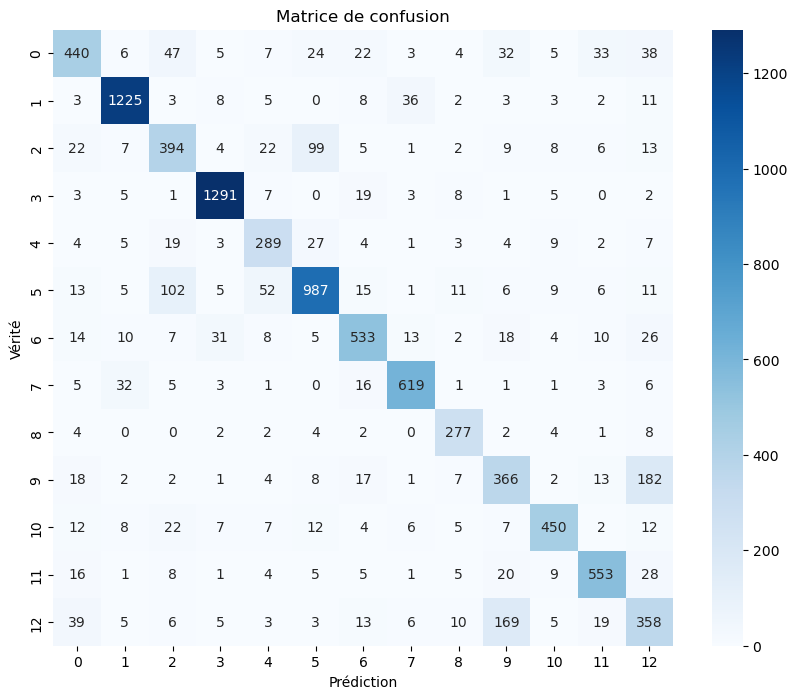

In [7]:
y_true = []
y_pred = []

for images, labels in test_df:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


cm = confusion_matrix(y_true, y_pred)
labels = list(range(13))


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.title("Matrice de confusion")
plt.show()


## Best hyperparameters

In [8]:
import tensorflow as tf
from tensorflow import keras

IMG_SIZE = (64, 64)
EPOCHS = 100
BATCH_SIZE = 64
SEEDS = [42, 69, 40, 55]
DATASET_PATH = "./dataset/ships32"

def prepare_datasets(seed):
    train_df, val_df = keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="both",
        seed=seed,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    normalization = keras.layers.Rescaling(1./255)
    augment = keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.1),
    ])

    AUTOTUNE = tf.data.AUTOTUNE
    train_df = train_df.map(lambda x, y: (normalization(augment(x)), y)).shuffle(1000).prefetch(AUTOTUNE)
    val_df = val_df.map(lambda x, y: (normalization(x), y)).prefetch(AUTOTUNE)
    return train_df, val_df



for seed in SEEDS:
    print(f"\nseed={seed}")

    model = make_model((IMG_SIZE[0], IMG_SIZE[1], 3), 13)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )

    train_df, val_df = prepare_datasets(seed)

    callbacks = [
        keras.callbacks.ModelCheckpoint(f"model_seed{seed}.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    ]

    history = model.fit(
        train_df,
        validation_data=val_df,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=2
    )

    print(f"End seed={seed}. Model saved : model_seed{seed}.h5")




seed=42
Found 48330 files belonging to 13 classes.
Using 38664 files for training.
Using 9666 files for validation.
Epoch 1/100


2025-08-05 20:09:13.699579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-05 20:09:24.052750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 322 of 1000
2025-08-05 20:09:32.847833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
/home/rickgao/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


605/605 - 47s - loss: 1.8624 - accuracy: 0.3877 - val_loss: 1.4903 - val_accuracy: 0.5028 - lr: 0.0010 - 47s/epoch - 77ms/step
Epoch 2/100


2025-08-05 20:10:07.801815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 338 of 1000
2025-08-05 20:10:17.022164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 1.3603 - accuracy: 0.5423 - val_loss: 1.4217 - val_accuracy: 0.5321 - lr: 0.0010 - 42s/epoch - 70ms/step
Epoch 3/100


2025-08-05 20:10:50.590341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 334 of 1000
2025-08-05 20:10:58.711996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 1.1872 - accuracy: 0.5986 - val_loss: 1.1268 - val_accuracy: 0.6205 - lr: 0.0010 - 41s/epoch - 68ms/step
Epoch 4/100


2025-08-05 20:11:32.039897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 336 of 1000
2025-08-05 20:11:40.745421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 1.0841 - accuracy: 0.6326 - val_loss: 1.1943 - val_accuracy: 0.5980 - lr: 0.0010 - 42s/epoch - 70ms/step
Epoch 5/100


2025-08-05 20:12:14.838083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 324 of 1000
2025-08-05 20:12:23.526529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 1.0122 - accuracy: 0.6544 - val_loss: 1.1085 - val_accuracy: 0.6411 - lr: 0.0010 - 42s/epoch - 69ms/step
Epoch 6/100


2025-08-05 20:12:57.019246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 20:13:04.827109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.9504 - accuracy: 0.6757 - val_loss: 0.9542 - val_accuracy: 0.6704 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 7/100


2025-08-05 20:13:36.999076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 20:13:45.116894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.9097 - accuracy: 0.6898 - val_loss: 0.8982 - val_accuracy: 0.6945 - lr: 0.0010 - 40s/epoch - 67ms/step
Epoch 8/100


2025-08-05 20:14:17.577468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 20:14:25.605745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.8741 - accuracy: 0.6982 - val_loss: 0.8932 - val_accuracy: 0.6958 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 9/100


2025-08-05 20:14:57.850907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 20:15:05.592106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.8362 - accuracy: 0.7116 - val_loss: 0.9212 - val_accuracy: 0.6909 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 10/100


2025-08-05 20:15:37.159558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 20:15:44.929004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.8164 - accuracy: 0.7177 - val_loss: 0.8251 - val_accuracy: 0.7207 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 11/100


2025-08-05 20:16:16.752124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 347 of 1000
2025-08-05 20:16:24.432343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.7888 - accuracy: 0.7277 - val_loss: 0.7989 - val_accuracy: 0.7285 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 12/100


2025-08-05 20:16:57.185084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 20:17:05.247654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.7579 - accuracy: 0.7372 - val_loss: 0.7406 - val_accuracy: 0.7467 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 13/100


2025-08-05 20:17:37.206464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 20:17:45.214518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.7353 - accuracy: 0.7449 - val_loss: 0.8964 - val_accuracy: 0.7076 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 14/100


2025-08-05 20:18:16.959878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 335 of 1000
2025-08-05 20:18:25.669429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 43s - loss: 0.7196 - accuracy: 0.7506 - val_loss: 0.8109 - val_accuracy: 0.7222 - lr: 0.0010 - 43s/epoch - 70ms/step
Epoch 15/100


2025-08-05 20:18:59.912678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 325 of 1000
2025-08-05 20:19:08.617093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
605/605 - 43s - loss: 0.6991 - accuracy: 0.7559 - val_loss: 0.7714 - val_accuracy: 0.7372 - lr: 0.0010 - 43s/epoch - 71ms/step
Epoch 16/100


2025-08-05 20:19:43.102172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 20:19:51.195779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.6252 - accuracy: 0.7798 - val_loss: 0.7291 - val_accuracy: 0.7533 - lr: 5.0000e-04 - 42s/epoch - 70ms/step
Epoch 17/100


2025-08-05 20:20:25.680890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 329 of 1000
2025-08-05 20:20:34.231379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6014 - accuracy: 0.7877 - val_loss: 0.7519 - val_accuracy: 0.7533 - lr: 5.0000e-04 - 40s/epoch - 67ms/step
Epoch 18/100


2025-08-05 20:21:06.254390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 20:21:14.303989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5833 - accuracy: 0.7946 - val_loss: 0.6516 - val_accuracy: 0.7766 - lr: 5.0000e-04 - 40s/epoch - 67ms/step
Epoch 19/100


2025-08-05 20:21:46.991925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 20:21:54.777166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.5699 - accuracy: 0.7981 - val_loss: 0.6559 - val_accuracy: 0.7743 - lr: 5.0000e-04 - 41s/epoch - 67ms/step
Epoch 20/100


2025-08-05 20:22:27.878887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 325 of 1000
2025-08-05 20:22:36.578674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.5613 - accuracy: 0.8005 - val_loss: 0.6798 - val_accuracy: 0.7665 - lr: 5.0000e-04 - 42s/epoch - 69ms/step
Epoch 21/100


2025-08-05 20:23:10.156195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 330 of 1000
2025-08-05 20:23:18.760629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
605/605 - 42s - loss: 0.5480 - accuracy: 0.8062 - val_loss: 0.6801 - val_accuracy: 0.7696 - lr: 5.0000e-04 - 42s/epoch - 70ms/step
Epoch 22/100


2025-08-05 20:23:52.441607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 336 of 1000
2025-08-05 20:24:00.481158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5022 - accuracy: 0.8218 - val_loss: 0.6881 - val_accuracy: 0.7742 - lr: 2.5000e-04 - 40s/epoch - 65ms/step
Epoch 23/100


2025-08-05 20:24:32.149380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 20:24:40.070505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4880 - accuracy: 0.8248 - val_loss: 0.6197 - val_accuracy: 0.7885 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 24/100


2025-08-05 20:25:12.038913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 20:25:19.787180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4810 - accuracy: 0.8266 - val_loss: 0.6345 - val_accuracy: 0.7866 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 25/100


2025-08-05 20:25:51.547844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 20:25:59.301327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4752 - accuracy: 0.8299 - val_loss: 0.6335 - val_accuracy: 0.7899 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 26/100


2025-08-05 20:26:31.094649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 20:26:38.988086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
605/605 - 39s - loss: 0.4657 - accuracy: 0.8318 - val_loss: 0.6496 - val_accuracy: 0.7825 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 27/100


2025-08-05 20:27:10.734292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 20:27:18.586342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4439 - accuracy: 0.8401 - val_loss: 0.6210 - val_accuracy: 0.7958 - lr: 1.2500e-04 - 39s/epoch - 65ms/step
Epoch 28/100


2025-08-05 20:27:50.488930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 20:27:58.429597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4400 - accuracy: 0.8425 - val_loss: 0.6102 - val_accuracy: 0.7985 - lr: 1.2500e-04 - 40s/epoch - 66ms/step
Epoch 29/100


2025-08-05 20:28:31.052735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 331 of 1000
2025-08-05 20:28:39.518794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 43s - loss: 0.4331 - accuracy: 0.8442 - val_loss: 0.6132 - val_accuracy: 0.7993 - lr: 1.2500e-04 - 43s/epoch - 71ms/step
Epoch 30/100


2025-08-05 20:29:14.543436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 332 of 1000
2025-08-05 20:29:22.997844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 43s - loss: 0.4221 - accuracy: 0.8452 - val_loss: 0.6319 - val_accuracy: 0.7944 - lr: 1.2500e-04 - 43s/epoch - 71ms/step
Epoch 31/100


2025-08-05 20:29:57.456394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 331 of 1000
2025-08-05 20:30:05.877103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 31: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
605/605 - 43s - loss: 0.4262 - accuracy: 0.8458 - val_loss: 0.6326 - val_accuracy: 0.7891 - lr: 1.2500e-04 - 43s/epoch - 70ms/step
Epoch 32/100


2025-08-05 20:30:40.329370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 335 of 1000
2025-08-05 20:30:48.538423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.4100 - accuracy: 0.8539 - val_loss: 0.6183 - val_accuracy: 0.7976 - lr: 6.2500e-05 - 42s/epoch - 69ms/step
Epoch 33/100


2025-08-05 20:31:22.129145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 316 of 1000
2025-08-05 20:31:31.482758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.4080 - accuracy: 0.8524 - val_loss: 0.6172 - val_accuracy: 0.7975 - lr: 6.2500e-05 - 42s/epoch - 70ms/step
Epoch 34/100


2025-08-05 20:32:04.972707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 20:32:13.084756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 34: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
605/605 - 41s - loss: 0.4095 - accuracy: 0.8509 - val_loss: 0.6202 - val_accuracy: 0.7956 - lr: 6.2500e-05 - 41s/epoch - 67ms/step
Epoch 35/100


2025-08-05 20:32:45.588988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 20:32:53.428236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4017 - accuracy: 0.8552 - val_loss: 0.6176 - val_accuracy: 0.7980 - lr: 3.1250e-05 - 40s/epoch - 66ms/step
Epoch 36/100


2025-08-05 20:33:25.873157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 333 of 1000
2025-08-05 20:33:33.957914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.3990 - accuracy: 0.8564 - val_loss: 0.6206 - val_accuracy: 0.7964 - lr: 3.1250e-05 - 41s/epoch - 67ms/step
Epoch 37/100


2025-08-05 20:34:06.775764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 20:34:14.659534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 37: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
605/605 - 40s - loss: 0.3996 - accuracy: 0.8560 - val_loss: 0.6167 - val_accuracy: 0.7998 - lr: 3.1250e-05 - 40s/epoch - 67ms/step
Epoch 38/100


2025-08-05 20:34:47.282563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2164: Filling up shuffle buffer (this may take a while): 330 of 1000
2025-08-05 20:34:56.149474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 44s - loss: 0.3941 - accuracy: 0.8577 - val_loss: 0.6170 - val_accuracy: 0.7984 - lr: 1.5625e-05 - 44s/epoch - 73ms/step
End seed=42. Model saved : model_seed42.h5

seed=69
Found 48330 files belonging to 13 classes.
Using 38664 files for training.
Using 9666 files for validation.
Epoch 1/100


2025-08-05 20:35:32.005033: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-05 20:35:42.374284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 313 of 1000
2025-08-05 20:35:51.304408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 49s - loss: 1.8761 - accuracy: 0.3834 - val_loss: 1.5648 - val_accuracy: 0.4780 - lr: 0.0010 - 49s/epoch - 80ms/step
Epoch 2/100


2025-08-05 20:36:28.150724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 332 of 1000
2025-08-05 20:36:37.381408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 1.3588 - accuracy: 0.5403 - val_loss: 1.1697 - val_accuracy: 0.6022 - lr: 0.0010 - 42s/epoch - 69ms/step
Epoch 3/100


2025-08-05 20:37:10.235311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 337 of 1000
2025-08-05 20:37:18.245372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 1.1725 - accuracy: 0.6037 - val_loss: 1.0516 - val_accuracy: 0.6387 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 4/100


2025-08-05 20:37:50.284491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 20:37:58.353857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 1.0700 - accuracy: 0.6377 - val_loss: 1.0081 - val_accuracy: 0.6528 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 5/100


2025-08-05 20:38:30.499517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 347 of 1000
2025-08-05 20:38:38.115593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 1.0094 - accuracy: 0.6557 - val_loss: 0.9888 - val_accuracy: 0.6640 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 6/100


2025-08-05 20:39:09.960771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 20:39:18.025130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.9453 - accuracy: 0.6799 - val_loss: 1.0127 - val_accuracy: 0.6573 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 7/100


2025-08-05 20:39:50.067350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 333 of 1000
2025-08-05 20:39:58.151935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.9002 - accuracy: 0.6905 - val_loss: 0.9606 - val_accuracy: 0.6733 - lr: 0.0010 - 40s/epoch - 67ms/step
Epoch 8/100


2025-08-05 20:40:30.561545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 20:40:38.656880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.8659 - accuracy: 0.7026 - val_loss: 0.8271 - val_accuracy: 0.7151 - lr: 0.0010 - 40s/epoch - 65ms/step
Epoch 9/100


2025-08-05 20:41:10.494587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 20:41:18.254162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.8343 - accuracy: 0.7172 - val_loss: 0.8934 - val_accuracy: 0.6960 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 10/100


2025-08-05 20:41:49.831443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 20:41:57.617043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.7980 - accuracy: 0.7257 - val_loss: 0.8689 - val_accuracy: 0.7122 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 11/100


2025-08-05 20:42:30.284457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 336 of 1000
2025-08-05 20:42:38.216716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.7751 - accuracy: 0.7330 - val_loss: 0.7981 - val_accuracy: 0.7257 - lr: 0.0010 - 40s/epoch - 67ms/step
Epoch 12/100


2025-08-05 20:43:10.737959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 335 of 1000
2025-08-05 20:43:19.205817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 43s - loss: 0.7566 - accuracy: 0.7389 - val_loss: 0.7684 - val_accuracy: 0.7434 - lr: 0.0010 - 43s/epoch - 71ms/step
Epoch 13/100


2025-08-05 20:43:53.949220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 309 of 1000
2025-08-05 20:44:03.461066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 44s - loss: 0.7358 - accuracy: 0.7459 - val_loss: 0.8524 - val_accuracy: 0.7102 - lr: 0.0010 - 44s/epoch - 72ms/step
Epoch 14/100


2025-08-05 20:44:37.679886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 320 of 1000
2025-08-05 20:44:46.764067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 44s - loss: 0.7137 - accuracy: 0.7547 - val_loss: 0.7992 - val_accuracy: 0.7325 - lr: 0.0010 - 44s/epoch - 73ms/step
Epoch 15/100


2025-08-05 20:45:21.631962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 299 of 1000
2025-08-05 20:45:31.470173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 44s - loss: 0.6918 - accuracy: 0.7604 - val_loss: 0.7425 - val_accuracy: 0.7511 - lr: 0.0010 - 44s/epoch - 73ms/step
Epoch 16/100


2025-08-05 20:46:06.149929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 321 of 1000
2025-08-05 20:46:15.057277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 43s - loss: 0.6773 - accuracy: 0.7648 - val_loss: 0.7585 - val_accuracy: 0.7378 - lr: 0.0010 - 43s/epoch - 71ms/step
Epoch 17/100


2025-08-05 20:46:49.303895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 323 of 1000
2025-08-05 20:46:57.981944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.6697 - accuracy: 0.7683 - val_loss: 0.7248 - val_accuracy: 0.7556 - lr: 0.0010 - 42s/epoch - 70ms/step
Epoch 18/100


2025-08-05 20:47:31.961354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 321 of 1000
2025-08-05 20:47:40.741170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6453 - accuracy: 0.7747 - val_loss: 0.8704 - val_accuracy: 0.7196 - lr: 0.0010 - 40s/epoch - 67ms/step
Epoch 19/100


2025-08-05 20:48:12.622812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 328 of 1000
2025-08-05 20:48:21.018307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.6377 - accuracy: 0.7768 - val_loss: 0.6999 - val_accuracy: 0.7674 - lr: 0.0010 - 41s/epoch - 68ms/step
Epoch 20/100


2025-08-05 20:48:54.155536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 326 of 1000
2025-08-05 20:49:02.987119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 43s - loss: 0.6203 - accuracy: 0.7835 - val_loss: 0.7882 - val_accuracy: 0.7329 - lr: 0.0010 - 43s/epoch - 70ms/step
Epoch 21/100


2025-08-05 20:49:37.063701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 325 of 1000
2025-08-05 20:49:45.898238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6112 - accuracy: 0.7856 - val_loss: 0.7250 - val_accuracy: 0.7526 - lr: 0.0010 - 40s/epoch - 67ms/step
Epoch 22/100


2025-08-05 20:50:17.453790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 20:50:25.553158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.5958 - accuracy: 0.7906 - val_loss: 0.6836 - val_accuracy: 0.7671 - lr: 0.0010 - 42s/epoch - 69ms/step
Epoch 23/100


2025-08-05 20:50:59.801742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 313 of 1000
2025-08-05 20:51:09.052033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.5968 - accuracy: 0.7894 - val_loss: 0.6888 - val_accuracy: 0.7670 - lr: 0.0010 - 42s/epoch - 70ms/step
Epoch 24/100


2025-08-05 20:51:42.243565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 306 of 1000
2025-08-05 20:51:51.665054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 44s - loss: 0.5811 - accuracy: 0.7954 - val_loss: 0.6848 - val_accuracy: 0.7690 - lr: 0.0010 - 44s/epoch - 73ms/step
Epoch 25/100


2025-08-05 20:52:26.497854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 312 of 1000
2025-08-05 20:52:35.499725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
605/605 - 43s - loss: 0.5733 - accuracy: 0.7967 - val_loss: 0.7020 - val_accuracy: 0.7673 - lr: 0.0010 - 43s/epoch - 71ms/step
Epoch 26/100


2025-08-05 20:53:09.541821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 321 of 1000
2025-08-05 20:53:18.870826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 43s - loss: 0.5048 - accuracy: 0.8189 - val_loss: 0.6365 - val_accuracy: 0.7894 - lr: 5.0000e-04 - 43s/epoch - 70ms/step
Epoch 27/100


2025-08-05 20:53:52.411452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 20:54:00.314088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.4853 - accuracy: 0.8273 - val_loss: 0.6253 - val_accuracy: 0.7917 - lr: 5.0000e-04 - 42s/epoch - 69ms/step
Epoch 28/100


2025-08-05 20:54:34.360923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 310 of 1000
2025-08-05 20:54:43.895993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 44s - loss: 0.4646 - accuracy: 0.8351 - val_loss: 0.6261 - val_accuracy: 0.7955 - lr: 5.0000e-04 - 44s/epoch - 73ms/step
Epoch 29/100


2025-08-05 20:55:19.035033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 315 of 1000
2025-08-05 20:55:28.309049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.4643 - accuracy: 0.8336 - val_loss: 0.6449 - val_accuracy: 0.7888 - lr: 5.0000e-04 - 42s/epoch - 70ms/step
Epoch 30/100


2025-08-05 20:56:01.495297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 323 of 1000
2025-08-05 20:56:10.468752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
605/605 - 43s - loss: 0.4574 - accuracy: 0.8370 - val_loss: 0.6697 - val_accuracy: 0.7802 - lr: 5.0000e-04 - 43s/epoch - 71ms/step
Epoch 31/100


2025-08-05 20:56:44.547136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 326 of 1000
2025-08-05 20:56:52.962232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.4190 - accuracy: 0.8506 - val_loss: 0.6178 - val_accuracy: 0.8005 - lr: 2.5000e-04 - 41s/epoch - 67ms/step
Epoch 32/100


2025-08-05 20:57:25.211539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 20:57:32.997468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4059 - accuracy: 0.8527 - val_loss: 0.6124 - val_accuracy: 0.7981 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 33/100


2025-08-05 20:58:04.944691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 350 of 1000
2025-08-05 20:58:12.397309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4000 - accuracy: 0.8564 - val_loss: 0.6252 - val_accuracy: 0.7973 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 34/100


2025-08-05 20:58:44.117216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 20:58:51.913089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.3953 - accuracy: 0.8571 - val_loss: 0.6094 - val_accuracy: 0.8024 - lr: 2.5000e-04 - 40s/epoch - 66ms/step
Epoch 35/100


2025-08-05 20:59:24.177901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 354 of 1000
2025-08-05 20:59:31.684064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.3868 - accuracy: 0.8603 - val_loss: 0.6127 - val_accuracy: 0.8024 - lr: 2.5000e-04 - 40s/epoch - 67ms/step
Epoch 36/100


2025-08-05 21:00:04.613343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 21:00:12.353422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.3805 - accuracy: 0.8627 - val_loss: 0.6333 - val_accuracy: 0.8000 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 37/100


2025-08-05 21:00:44.161623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 348 of 1000
2025-08-05 21:00:51.685166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
605/605 - 41s - loss: 0.3808 - accuracy: 0.8620 - val_loss: 0.6258 - val_accuracy: 0.8026 - lr: 2.5000e-04 - 41s/epoch - 68ms/step
Epoch 38/100


2025-08-05 21:01:25.285367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 337 of 1000
2025-08-05 21:01:33.274808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.3629 - accuracy: 0.8696 - val_loss: 0.6085 - val_accuracy: 0.8088 - lr: 1.2500e-04 - 40s/epoch - 66ms/step
Epoch 39/100


2025-08-05 21:02:05.245317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 21:02:12.972672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.3551 - accuracy: 0.8719 - val_loss: 0.6212 - val_accuracy: 0.8057 - lr: 1.2500e-04 - 39s/epoch - 65ms/step
Epoch 40/100


2025-08-05 21:02:44.794332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:02:52.709379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.3513 - accuracy: 0.8729 - val_loss: 0.6144 - val_accuracy: 0.8079 - lr: 1.2500e-04 - 41s/epoch - 68ms/step
Epoch 41/100


2025-08-05 21:03:25.991721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 330 of 1000
2025-08-05 21:03:34.591693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 41: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
605/605 - 43s - loss: 0.3475 - accuracy: 0.8729 - val_loss: 0.6187 - val_accuracy: 0.8070 - lr: 1.2500e-04 - 43s/epoch - 71ms/step
Epoch 42/100


2025-08-05 21:04:08.942250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 307 of 1000
2025-08-05 21:04:18.755715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 44s - loss: 0.3373 - accuracy: 0.8756 - val_loss: 0.6179 - val_accuracy: 0.8102 - lr: 6.2500e-05 - 44s/epoch - 73ms/step
Epoch 43/100


2025-08-05 21:04:53.246444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 302 of 1000
2025-08-05 21:05:02.770174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.3355 - accuracy: 0.8768 - val_loss: 0.6180 - val_accuracy: 0.8091 - lr: 6.2500e-05 - 42s/epoch - 70ms/step
Epoch 44/100


2025-08-05 21:05:35.691865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 317 of 1000
2025-08-05 21:05:44.196026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 44: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
605/605 - 40s - loss: 0.3330 - accuracy: 0.8783 - val_loss: 0.6164 - val_accuracy: 0.8121 - lr: 6.2500e-05 - 40s/epoch - 66ms/step
Epoch 45/100


2025-08-05 21:06:16.140377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 21:06:23.769394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.3300 - accuracy: 0.8797 - val_loss: 0.6133 - val_accuracy: 0.8110 - lr: 3.1250e-05 - 39s/epoch - 65ms/step
Epoch 46/100


2025-08-05 21:06:55.487942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 21:07:03.146547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.3310 - accuracy: 0.8771 - val_loss: 0.6125 - val_accuracy: 0.8102 - lr: 3.1250e-05 - 39s/epoch - 65ms/step
Epoch 47/100


2025-08-05 21:07:35.028730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 345 of 1000
2025-08-05 21:07:42.684340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 47: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
605/605 - 39s - loss: 0.3237 - accuracy: 0.8822 - val_loss: 0.6115 - val_accuracy: 0.8098 - lr: 3.1250e-05 - 39s/epoch - 65ms/step
Epoch 48/100


2025-08-05 21:08:14.555692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2184: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 21:08:22.187559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.3247 - accuracy: 0.8825 - val_loss: 0.6108 - val_accuracy: 0.8104 - lr: 1.5625e-05 - 39s/epoch - 65ms/step
End seed=69. Model saved : model_seed69.h5

seed=40
Found 48330 files belonging to 13 classes.
Using 38664 files for training.
Using 9666 files for validation.
Epoch 1/100


2025-08-05 21:08:52.967443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-05 21:09:03.271017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 332 of 1000
2025-08-05 21:09:11.370451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 46s - loss: 1.8660 - accuracy: 0.3826 - val_loss: 1.6188 - val_accuracy: 0.4442 - lr: 0.0010 - 46s/epoch - 76ms/step
Epoch 2/100


2025-08-05 21:09:47.239046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 21:09:55.195256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 1.3697 - accuracy: 0.5378 - val_loss: 1.1953 - val_accuracy: 0.5860 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 3/100


2025-08-05 21:10:27.341230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 337 of 1000
2025-08-05 21:10:35.355967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 1.1728 - accuracy: 0.6047 - val_loss: 1.1047 - val_accuracy: 0.6215 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 4/100


2025-08-05 21:11:07.477968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 350 of 1000
2025-08-05 21:11:15.106011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 1.0675 - accuracy: 0.6372 - val_loss: 1.1563 - val_accuracy: 0.6045 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 5/100


2025-08-05 21:11:46.813231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:11:54.613452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.9991 - accuracy: 0.6606 - val_loss: 1.0685 - val_accuracy: 0.6288 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 6/100


2025-08-05 21:12:27.364809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 352 of 1000
2025-08-05 21:12:34.901706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.9456 - accuracy: 0.6785 - val_loss: 0.8986 - val_accuracy: 0.6980 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 7/100


2025-08-05 21:13:06.924574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 21:13:14.924805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.9052 - accuracy: 0.6900 - val_loss: 0.9285 - val_accuracy: 0.6821 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 8/100


2025-08-05 21:13:47.899261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 349 of 1000
2025-08-05 21:13:55.622277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.8758 - accuracy: 0.7002 - val_loss: 0.9461 - val_accuracy: 0.6788 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 9/100


2025-08-05 21:14:27.467273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 21:14:35.258684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
605/605 - 39s - loss: 0.8413 - accuracy: 0.7116 - val_loss: 0.9099 - val_accuracy: 0.6898 - lr: 0.0010 - 39s/epoch - 65ms/step
Epoch 10/100


2025-08-05 21:15:07.211235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 347 of 1000
2025-08-05 21:15:14.894906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.7482 - accuracy: 0.7421 - val_loss: 0.7604 - val_accuracy: 0.7390 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 11/100


2025-08-05 21:15:47.226508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:15:55.100429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.7059 - accuracy: 0.7536 - val_loss: 0.7211 - val_accuracy: 0.7551 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 12/100


2025-08-05 21:16:27.527515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:16:35.417955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6897 - accuracy: 0.7601 - val_loss: 0.7215 - val_accuracy: 0.7514 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 13/100


2025-08-05 21:17:07.507531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 333 of 1000
2025-08-05 21:17:15.732280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6786 - accuracy: 0.7632 - val_loss: 0.7128 - val_accuracy: 0.7548 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 14/100


2025-08-05 21:17:47.720449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 347 of 1000
2025-08-05 21:17:55.359369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.6557 - accuracy: 0.7724 - val_loss: 0.7443 - val_accuracy: 0.7473 - lr: 5.0000e-04 - 39s/epoch - 65ms/step
Epoch 15/100


2025-08-05 21:18:27.289742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 338 of 1000
2025-08-05 21:18:35.293801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6424 - accuracy: 0.7755 - val_loss: 0.6829 - val_accuracy: 0.7673 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 16/100


2025-08-05 21:19:07.588207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 21:19:15.290032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6259 - accuracy: 0.7831 - val_loss: 0.7122 - val_accuracy: 0.7582 - lr: 5.0000e-04 - 40s/epoch - 65ms/step
Epoch 17/100


2025-08-05 21:19:47.414142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:19:55.300715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6162 - accuracy: 0.7820 - val_loss: 0.7759 - val_accuracy: 0.7479 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 18/100


2025-08-05 21:20:27.393747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 354 of 1000
2025-08-05 21:20:34.722767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
605/605 - 39s - loss: 0.6059 - accuracy: 0.7882 - val_loss: 0.6911 - val_accuracy: 0.7657 - lr: 5.0000e-04 - 39s/epoch - 64ms/step
Epoch 19/100


2025-08-05 21:21:06.590690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:21:14.455829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5574 - accuracy: 0.8035 - val_loss: 0.6674 - val_accuracy: 0.7763 - lr: 2.5000e-04 - 40s/epoch - 66ms/step
Epoch 20/100


2025-08-05 21:21:46.793761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 352 of 1000
2025-08-05 21:21:54.248605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.5389 - accuracy: 0.8101 - val_loss: 0.6290 - val_accuracy: 0.7864 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 21/100


2025-08-05 21:22:26.347436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:22:34.186987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5302 - accuracy: 0.8109 - val_loss: 0.6357 - val_accuracy: 0.7873 - lr: 2.5000e-04 - 40s/epoch - 66ms/step
Epoch 22/100


2025-08-05 21:23:06.434635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 350 of 1000
2025-08-05 21:23:14.070296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5177 - accuracy: 0.8155 - val_loss: 0.6501 - val_accuracy: 0.7828 - lr: 2.5000e-04 - 40s/epoch - 65ms/step
Epoch 23/100


2025-08-05 21:23:46.151702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 21:23:54.103230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5129 - accuracy: 0.8187 - val_loss: 0.6206 - val_accuracy: 0.7912 - lr: 2.5000e-04 - 40s/epoch - 66ms/step
Epoch 24/100


2025-08-05 21:24:26.319554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 352 of 1000
2025-08-05 21:24:33.822229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5050 - accuracy: 0.8198 - val_loss: 0.6387 - val_accuracy: 0.7884 - lr: 2.5000e-04 - 40s/epoch - 65ms/step
Epoch 25/100


2025-08-05 21:25:05.958676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 336 of 1000
2025-08-05 21:25:14.111443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4948 - accuracy: 0.8240 - val_loss: 0.6279 - val_accuracy: 0.7912 - lr: 2.5000e-04 - 40s/epoch - 66ms/step
Epoch 26/100


2025-08-05 21:25:46.217383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 21:25:54.047007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
605/605 - 39s - loss: 0.4929 - accuracy: 0.8216 - val_loss: 0.6506 - val_accuracy: 0.7837 - lr: 2.5000e-04 - 39s/epoch - 65ms/step
Epoch 27/100


2025-08-05 21:26:25.945263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 348 of 1000
2025-08-05 21:26:33.521458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4658 - accuracy: 0.8313 - val_loss: 0.6313 - val_accuracy: 0.7951 - lr: 1.2500e-04 - 39s/epoch - 65ms/step
Epoch 28/100


2025-08-05 21:27:05.627085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 349 of 1000
2025-08-05 21:27:13.331921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4529 - accuracy: 0.8367 - val_loss: 0.6197 - val_accuracy: 0.7934 - lr: 1.2500e-04 - 39s/epoch - 65ms/step
Epoch 29/100


2025-08-05 21:27:45.293355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 21:27:52.976856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4498 - accuracy: 0.8388 - val_loss: 0.6181 - val_accuracy: 0.7955 - lr: 1.2500e-04 - 39s/epoch - 65ms/step
Epoch 30/100


2025-08-05 21:28:24.842200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 348 of 1000
2025-08-05 21:28:32.353923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4459 - accuracy: 0.8396 - val_loss: 0.6258 - val_accuracy: 0.7935 - lr: 1.2500e-04 - 39s/epoch - 64ms/step
Epoch 31/100


2025-08-05 21:29:04.079748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 21:29:11.966124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4374 - accuracy: 0.8444 - val_loss: 0.6293 - val_accuracy: 0.7967 - lr: 1.2500e-04 - 39s/epoch - 65ms/step
Epoch 32/100


2025-08-05 21:29:43.992649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 347 of 1000
2025-08-05 21:29:51.658695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 32: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
605/605 - 39s - loss: 0.4325 - accuracy: 0.8435 - val_loss: 0.6309 - val_accuracy: 0.7921 - lr: 1.2500e-04 - 39s/epoch - 65ms/step
Epoch 33/100


2025-08-05 21:30:23.432608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 21:30:31.324396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4215 - accuracy: 0.8473 - val_loss: 0.6093 - val_accuracy: 0.7990 - lr: 6.2500e-05 - 40s/epoch - 65ms/step
Epoch 34/100


2025-08-05 21:31:03.431245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 348 of 1000
2025-08-05 21:31:11.146216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4208 - accuracy: 0.8475 - val_loss: 0.6159 - val_accuracy: 0.8006 - lr: 6.2500e-05 - 40s/epoch - 66ms/step
Epoch 35/100


2025-08-05 21:31:43.310264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:31:51.345402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4134 - accuracy: 0.8501 - val_loss: 0.6168 - val_accuracy: 0.8003 - lr: 6.2500e-05 - 40s/epoch - 65ms/step
Epoch 36/100


2025-08-05 21:32:23.207574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 356 of 1000
2025-08-05 21:32:30.502364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 36: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
605/605 - 39s - loss: 0.4147 - accuracy: 0.8508 - val_loss: 0.6211 - val_accuracy: 0.7998 - lr: 6.2500e-05 - 39s/epoch - 64ms/step
Epoch 37/100


2025-08-05 21:33:02.368435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 337 of 1000
2025-08-05 21:33:10.451376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4082 - accuracy: 0.8512 - val_loss: 0.6108 - val_accuracy: 0.8011 - lr: 3.1250e-05 - 40s/epoch - 67ms/step
Epoch 38/100


2025-08-05 21:33:42.760246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 21:33:50.695974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4069 - accuracy: 0.8519 - val_loss: 0.6191 - val_accuracy: 0.8013 - lr: 3.1250e-05 - 40s/epoch - 65ms/step
Epoch 39/100


2025-08-05 21:34:22.666080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:34:30.509798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 39: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
605/605 - 40s - loss: 0.4064 - accuracy: 0.8536 - val_loss: 0.6135 - val_accuracy: 0.8007 - lr: 3.1250e-05 - 40s/epoch - 66ms/step
Epoch 40/100


2025-08-05 21:35:02.648612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 21:35:10.334797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4020 - accuracy: 0.8533 - val_loss: 0.6120 - val_accuracy: 0.8026 - lr: 1.5625e-05 - 39s/epoch - 65ms/step
Epoch 41/100


2025-08-05 21:35:42.265546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:35:50.082385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.3958 - accuracy: 0.8564 - val_loss: 0.6107 - val_accuracy: 0.8035 - lr: 1.5625e-05 - 39s/epoch - 65ms/step
Epoch 42/100


2025-08-05 21:36:22.120791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:36:30.084496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 42: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
605/605 - 40s - loss: 0.3968 - accuracy: 0.8552 - val_loss: 0.6138 - val_accuracy: 0.8021 - lr: 1.5625e-05 - 40s/epoch - 65ms/step
Epoch 43/100


2025-08-05 21:37:02.005459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2204: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:37:09.852351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.3940 - accuracy: 0.8559 - val_loss: 0.6125 - val_accuracy: 0.8027 - lr: 7.8125e-06 - 39s/epoch - 65ms/step
End seed=40. Model saved : model_seed40.h5

seed=55
Found 48330 files belonging to 13 classes.
Using 38664 files for training.
Using 9666 files for validation.
Epoch 1/100


2025-08-05 21:37:40.915678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-05 21:37:51.207197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 332 of 1000
2025-08-05 21:37:59.320853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 45s - loss: 1.8588 - accuracy: 0.3834 - val_loss: 1.6249 - val_accuracy: 0.4537 - lr: 0.0010 - 45s/epoch - 74ms/step
Epoch 2/100


2025-08-05 21:38:33.413339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:38:41.475105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 1.3695 - accuracy: 0.5399 - val_loss: 1.3473 - val_accuracy: 0.5596 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 3/100


2025-08-05 21:39:13.940551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 338 of 1000
2025-08-05 21:39:21.910058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 1.1886 - accuracy: 0.5997 - val_loss: 1.1574 - val_accuracy: 0.6136 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 4/100


2025-08-05 21:39:54.118184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:40:01.943568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 1.0732 - accuracy: 0.6374 - val_loss: 1.0501 - val_accuracy: 0.6457 - lr: 0.0010 - 41s/epoch - 68ms/step
Epoch 5/100


2025-08-05 21:40:35.460894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 21:40:43.405649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 1.0056 - accuracy: 0.6579 - val_loss: 1.1118 - val_accuracy: 0.6185 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 6/100


2025-08-05 21:41:15.620088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:41:23.722975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.9474 - accuracy: 0.6794 - val_loss: 0.9521 - val_accuracy: 0.6763 - lr: 0.0010 - 42s/epoch - 69ms/step
Epoch 7/100


2025-08-05 21:41:57.715405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 320 of 1000
2025-08-05 21:42:06.820779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.9036 - accuracy: 0.6898 - val_loss: 1.2399 - val_accuracy: 0.5951 - lr: 0.0010 - 41s/epoch - 68ms/step
Epoch 8/100


2025-08-05 21:42:39.025388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:42:47.202131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.8672 - accuracy: 0.7039 - val_loss: 0.7935 - val_accuracy: 0.7312 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 9/100


2025-08-05 21:43:19.478990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 350 of 1000
2025-08-05 21:43:27.124173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.8328 - accuracy: 0.7159 - val_loss: 1.2280 - val_accuracy: 0.5931 - lr: 0.0010 - 40s/epoch - 65ms/step
Epoch 10/100


2025-08-05 21:43:59.371955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 332 of 1000
2025-08-05 21:44:07.508954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.8136 - accuracy: 0.7219 - val_loss: 0.8368 - val_accuracy: 0.7127 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 11/100


2025-08-05 21:44:39.328038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 349 of 1000
2025-08-05 21:44:46.843614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
605/605 - 40s - loss: 0.7839 - accuracy: 0.7296 - val_loss: 0.8851 - val_accuracy: 0.7045 - lr: 0.0010 - 40s/epoch - 66ms/step
Epoch 12/100


2025-08-05 21:45:19.164974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:45:27.066103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6964 - accuracy: 0.7574 - val_loss: 0.6933 - val_accuracy: 0.7568 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 13/100


2025-08-05 21:45:59.186243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 21:46:07.178375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6649 - accuracy: 0.7687 - val_loss: 0.7074 - val_accuracy: 0.7547 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 14/100


2025-08-05 21:46:39.120887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 21:46:46.849861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6532 - accuracy: 0.7708 - val_loss: 0.6731 - val_accuracy: 0.7664 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 15/100


2025-08-05 21:47:18.982365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 343 of 1000
2025-08-05 21:47:26.790565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.6328 - accuracy: 0.7773 - val_loss: 0.6766 - val_accuracy: 0.7721 - lr: 5.0000e-04 - 39s/epoch - 65ms/step
Epoch 16/100


2025-08-05 21:47:58.673856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 21:48:06.718862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.6217 - accuracy: 0.7825 - val_loss: 0.6888 - val_accuracy: 0.7658 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 17/100


2025-08-05 21:48:38.701558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 335 of 1000
2025-08-05 21:48:46.888507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
605/605 - 40s - loss: 0.6129 - accuracy: 0.7829 - val_loss: 0.6983 - val_accuracy: 0.7611 - lr: 5.0000e-04 - 40s/epoch - 66ms/step
Epoch 18/100


2025-08-05 21:49:18.913645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:49:26.822420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5625 - accuracy: 0.8000 - val_loss: 0.6236 - val_accuracy: 0.7852 - lr: 2.5000e-04 - 40s/epoch - 65ms/step
Epoch 19/100


2025-08-05 21:49:58.794104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 21:50:06.665582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5484 - accuracy: 0.8056 - val_loss: 0.6725 - val_accuracy: 0.7735 - lr: 2.5000e-04 - 40s/epoch - 67ms/step
Epoch 20/100


2025-08-05 21:50:39.510904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 324 of 1000
2025-08-05 21:50:48.062601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5347 - accuracy: 0.8096 - val_loss: 0.6258 - val_accuracy: 0.7881 - lr: 2.5000e-04 - 40s/epoch - 67ms/step
Epoch 21/100


2025-08-05 21:51:20.339649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:51:28.201856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
605/605 - 40s - loss: 0.5254 - accuracy: 0.8141 - val_loss: 0.6315 - val_accuracy: 0.7823 - lr: 2.5000e-04 - 40s/epoch - 66ms/step
Epoch 22/100


2025-08-05 21:52:00.232544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 347 of 1000
2025-08-05 21:52:08.091108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.5030 - accuracy: 0.8204 - val_loss: 0.6146 - val_accuracy: 0.7903 - lr: 1.2500e-04 - 40s/epoch - 66ms/step
Epoch 23/100


2025-08-05 21:52:40.213215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 21:52:48.781012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4933 - accuracy: 0.8229 - val_loss: 0.6118 - val_accuracy: 0.7912 - lr: 1.2500e-04 - 40s/epoch - 67ms/step
Epoch 24/100


2025-08-05 21:53:21.037857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 348 of 1000
2025-08-05 21:53:28.707894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4858 - accuracy: 0.8255 - val_loss: 0.6108 - val_accuracy: 0.7942 - lr: 1.2500e-04 - 40s/epoch - 67ms/step
Epoch 25/100


2025-08-05 21:54:01.359560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:54:09.266863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4797 - accuracy: 0.8279 - val_loss: 0.6196 - val_accuracy: 0.7912 - lr: 1.2500e-04 - 40s/epoch - 65ms/step
Epoch 26/100


2025-08-05 21:54:41.172756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 21:54:49.007382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4774 - accuracy: 0.8285 - val_loss: 0.6319 - val_accuracy: 0.7886 - lr: 1.2500e-04 - 40s/epoch - 66ms/step
Epoch 27/100


2025-08-05 21:55:21.231496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 21:55:29.177625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
605/605 - 40s - loss: 0.4686 - accuracy: 0.8322 - val_loss: 0.6207 - val_accuracy: 0.7913 - lr: 1.2500e-04 - 40s/epoch - 65ms/step
Epoch 28/100


2025-08-05 21:56:01.120611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 348 of 1000
2025-08-05 21:56:08.831633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4588 - accuracy: 0.8331 - val_loss: 0.6076 - val_accuracy: 0.7968 - lr: 6.2500e-05 - 40s/epoch - 66ms/step
Epoch 29/100


2025-08-05 21:56:40.812087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 337 of 1000
2025-08-05 21:56:48.877677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4579 - accuracy: 0.8359 - val_loss: 0.6095 - val_accuracy: 0.7962 - lr: 6.2500e-05 - 40s/epoch - 65ms/step
Epoch 30/100


2025-08-05 21:57:20.783455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 340 of 1000
2025-08-05 21:57:28.708008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4488 - accuracy: 0.8379 - val_loss: 0.6076 - val_accuracy: 0.7952 - lr: 6.2500e-05 - 40s/epoch - 66ms/step
Epoch 31/100


2025-08-05 21:58:00.826645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 21:58:08.570783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 31: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
605/605 - 39s - loss: 0.4486 - accuracy: 0.8389 - val_loss: 0.6128 - val_accuracy: 0.7955 - lr: 6.2500e-05 - 39s/epoch - 65ms/step
Epoch 32/100


2025-08-05 21:58:40.485242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 352 of 1000
2025-08-05 21:58:47.921785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4428 - accuracy: 0.8421 - val_loss: 0.6072 - val_accuracy: 0.8002 - lr: 3.1250e-05 - 40s/epoch - 66ms/step
Epoch 33/100


2025-08-05 21:59:21.465074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 341 of 1000
2025-08-05 21:59:29.308669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4357 - accuracy: 0.8420 - val_loss: 0.6083 - val_accuracy: 0.8006 - lr: 3.1250e-05 - 40s/epoch - 66ms/step
Epoch 34/100


2025-08-05 22:00:01.632857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 342 of 1000
2025-08-05 22:00:09.453123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 40s - loss: 0.4420 - accuracy: 0.8404 - val_loss: 0.6081 - val_accuracy: 0.7978 - lr: 3.1250e-05 - 40s/epoch - 65ms/step
Epoch 35/100


2025-08-05 22:00:41.355461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 357 of 1000
2025-08-05 22:00:48.475595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 35: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
605/605 - 39s - loss: 0.4369 - accuracy: 0.8423 - val_loss: 0.6093 - val_accuracy: 0.7982 - lr: 3.1250e-05 - 39s/epoch - 64ms/step
Epoch 36/100


2025-08-05 22:01:20.293691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 348 of 1000
2025-08-05 22:01:27.913700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 39s - loss: 0.4362 - accuracy: 0.8438 - val_loss: 0.6065 - val_accuracy: 0.7988 - lr: 1.5625e-05 - 39s/epoch - 65ms/step
Epoch 37/100


2025-08-05 22:01:59.854788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 346 of 1000
2025-08-05 22:02:07.620987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 42s - loss: 0.4359 - accuracy: 0.8420 - val_loss: 0.6062 - val_accuracy: 0.8001 - lr: 1.5625e-05 - 42s/epoch - 69ms/step
Epoch 38/100


2025-08-05 22:02:41.777464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 321 of 1000
2025-08-05 22:02:50.255024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.4279 - accuracy: 0.8460 - val_loss: 0.6071 - val_accuracy: 0.8007 - lr: 1.5625e-05 - 41s/epoch - 69ms/step
Epoch 39/100


2025-08-05 22:03:23.578023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 336 of 1000
2025-08-05 22:03:31.730247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.4280 - accuracy: 0.8440 - val_loss: 0.6073 - val_accuracy: 0.7995 - lr: 1.5625e-05 - 41s/epoch - 68ms/step
Epoch 40/100


2025-08-05 22:04:04.889288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 337 of 1000
2025-08-05 22:04:12.980777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 40: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
605/605 - 41s - loss: 0.4293 - accuracy: 0.8439 - val_loss: 0.6071 - val_accuracy: 0.8004 - lr: 1.5625e-05 - 41s/epoch - 68ms/step
Epoch 41/100


2025-08-05 22:04:46.351338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 339 of 1000
2025-08-05 22:04:54.373942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.4282 - accuracy: 0.8464 - val_loss: 0.6083 - val_accuracy: 0.7999 - lr: 7.8125e-06 - 41s/epoch - 68ms/step
Epoch 42/100


2025-08-05 22:05:27.483971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 335 of 1000
2025-08-05 22:05:35.684197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.4236 - accuracy: 0.8487 - val_loss: 0.6073 - val_accuracy: 0.7996 - lr: 7.8125e-06 - 41s/epoch - 68ms/step
Epoch 43/100


2025-08-05 22:06:08.948593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 328 of 1000
2025-08-05 22:06:17.262188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 43: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
605/605 - 41s - loss: 0.4300 - accuracy: 0.8456 - val_loss: 0.6073 - val_accuracy: 0.8003 - lr: 7.8125e-06 - 41s/epoch - 68ms/step
Epoch 44/100


2025-08-05 22:06:50.489095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 344 of 1000
2025-08-05 22:06:58.325909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.4297 - accuracy: 0.8456 - val_loss: 0.6068 - val_accuracy: 0.7997 - lr: 3.9063e-06 - 41s/epoch - 68ms/step
Epoch 45/100


2025-08-05 22:07:31.825329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 347 of 1000
2025-08-05 22:07:39.708819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.4256 - accuracy: 0.8468 - val_loss: 0.6072 - val_accuracy: 0.7998 - lr: 3.9063e-06 - 41s/epoch - 67ms/step
Epoch 46/100


2025-08-05 22:08:12.877056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 336 of 1000
2025-08-05 22:08:20.871101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 46: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
605/605 - 41s - loss: 0.4298 - accuracy: 0.8445 - val_loss: 0.6077 - val_accuracy: 0.8001 - lr: 3.9063e-06 - 41s/epoch - 67ms/step
Epoch 47/100


2025-08-05 22:08:53.868847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2224: Filling up shuffle buffer (this may take a while): 333 of 1000
2025-08-05 22:09:02.076245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


605/605 - 41s - loss: 0.4252 - accuracy: 0.8447 - val_loss: 0.6073 - val_accuracy: 0.7996 - lr: 1.9531e-06 - 41s/epoch - 68ms/step
End seed=55. Model saved : model_seed55.h5


In [1]:
from tensorflow import keras

seed = 69
model_path = f"model_seed{seed}.h5"

model = keras.models.load_model(model_path)

model.summary()


2025-05-31 09:35:34.985501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 09:35:34.985591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 09:35:34.990457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 09:35:35.339094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-31 09:35:37.833252: W tensorflow/compiler/

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_16 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_17 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 32, 32)        0   

# Résultat à soumettre
## Load le dataset de test

In [9]:
import numpy as np

X_test = np.load('./dataset/ships_competition.npz', allow_pickle=True)['X']
X_test = X_test.astype('float32') / 255

## Predict et exporter en csv

In [10]:
import tensorflow as tf
import pandas as pd

# Resize les images
X_test_resized = tf.image.resize(X_test, size=(64, 64)).numpy()

# Predict avec notre modèle
res = model.predict(X_test_resized).argmax(axis=1)

# Export en csv
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

63/63 [==============================] - 1s 12ms/step


In [11]:
np.unique(pd.read_csv("submission.csv").values[:,1])

#pd.read_csv("submission.csv")

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [12]:
!head submission.csv

Id,Category
0,5
1,3
2,8
3,6
4,5
5,0
6,1
7,1
8,3


In [ ]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')